In [38]:
import torch
import pandas as pd
import numpy as np
import torch.utils
import torchvision.transforms
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
#Loading house prices training and test dataset
hptrain = pd.read_csv("Datasets/hptrain.csv",index_col=0)
hptest = pd.read_csv("Datasets/hptest.csv",index_col=0)

In [40]:
#Transforming data into tensor data format from pandas' dataframe
X_ols_train = torch.tensor(hptrain[['LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'TotalBsmtSF']].values,requires_grad=True,dtype=torch.float32)
X_ols_train = nn.functional.normalize(X_ols_train)
Y_ols_train = torch.tensor(hptrain[['SalePrice']].values,requires_grad=True,dtype=torch.float32)


#Splitting data into iterable batches
olstensor = torch.utils.data.TensorDataset(X_ols_train,Y_ols_train)
olsdataloader = torch.utils.data.DataLoader(olstensor, batch_size=20,shuffle=True)

In [41]:
#Specifying the paramenters of our model
olsnet = nn.Sequential(nn.Linear(X_ols_train.size()[1],Y_ols_train.size()[1]))
olsnet[0].weight.data.normal_(0, 0.1)
olsnet[0].bias.data.normal_(0, 0.1)
olsloss = nn.MSELoss()
olstrainer = torch.optim.SGD(olsnet.parameters(),lr=0.0001)

In [42]:
num_epochs = 5000
olsnet.train()
for epoch in range(num_epochs):
    print('-------------------')
    print(f'{epoch+1}th epoch')
    print('===================')
    olstrainer.zero_grad()
    X, Y = next(iter(olsdataloader))
    output = olsnet(X)

    l = olsloss(output,Y)
    print(f'Loss ols:{l}')


    l.backward(retain_graph=True)

    olstrainer.step()
    print('Coefficients: ',olsnet[0].weight.data)


-------------------
1th epoch
Loss ols:32288706560.0
Coefficients:  tensor([[ 3.2264e+01,  1.3175e-01, -3.8167e-03,  3.0734e-01,  3.6866e+00]])
-------------------
2th epoch
Loss ols:nan
Coefficients:  tensor([[nan, nan, nan, nan, nan]])
-------------------
3th epoch
Loss ols:nan
Coefficients:  tensor([[nan, nan, nan, nan, nan]])
-------------------
4th epoch
Loss ols:nan
Coefficients:  tensor([[nan, nan, nan, nan, nan]])
-------------------
5th epoch
Loss ols:nan
Coefficients:  tensor([[nan, nan, nan, nan, nan]])
-------------------
6th epoch
Loss ols:nan
Coefficients:  tensor([[nan, nan, nan, nan, nan]])
-------------------
7th epoch
Loss ols:nan
Coefficients:  tensor([[nan, nan, nan, nan, nan]])
-------------------
8th epoch
Loss ols:nan
Coefficients:  tensor([[nan, nan, nan, nan, nan]])
-------------------
9th epoch
Loss ols:nan
Coefficients:  tensor([[nan, nan, nan, nan, nan]])
-------------------
10th epoch
Loss ols:nan
Coefficients:  tensor([[nan, nan, nan, nan, nan]])
---------

In [43]:
'''--------------------------------------------------------'''
'''--------------------------------------------------------'''
'''--------------------------------------------------------'''

'--------------------------------------------------------'

In [44]:
#Loading in complex MNIST train and test datasets while transforming them to 64
trans = [torchvision.transforms.ToTensor()]
trans.insert(0, torchvision.transforms.Resize(64))
trans = torchvision.transforms.Compose(trans)


mnist_train = torchvision.datasets.FashionMNIST(
    root="../PyTorch_Basic/Datasets",train = True, transform=trans, download= True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../PyTorch_Basic/Datasets",train = False, transform=trans, download= True)

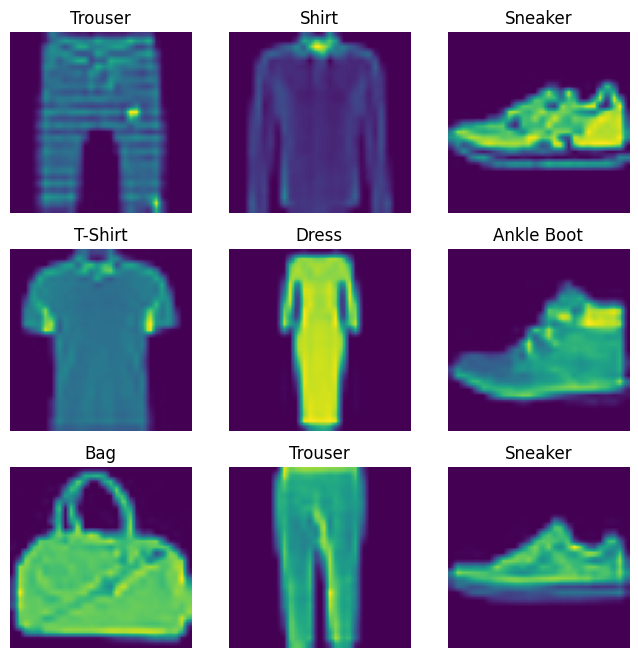

In [45]:
#Visualizing 9 random examples

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train), size=(1,)).item()
    img, label = mnist_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()



In [46]:
#Splitting our data into batch sizes
mnist_batch_size = 4

mnist_train_iter = torch.utils.data.DataLoader(mnist_train,mnist_batch_size,shuffle=True,num_workers=4)
mnist_test_iter = torch.utils.data.DataLoader(mnist_test,mnist_batch_size,shuffle=True,num_workers=4)

In [47]:
#Creating the model and initializing the weights
logit_net = nn.Sequential(nn.Flatten(),nn.Linear(784,10))

#Initializing weights
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

logit_net.apply(init_weights)

#Specifying cross entropy loss
logit_loss = nn.CrossEntropyLoss(reduction='none')

#Specifying Stochastic Gradient Descent trainer
logit_trainer = torch.optim.SGD(logit_net.parameters(), lr=0.1)